# Predicción de demanda (Celda SM04)
Integrantes:
* Andrea Turriate
* Diego Perez
* Jose Matienzo
* Fabio Neyra
* Hector Diaz
* Yolmer Daza

Este notebook implementa un modelo de **Random Forest Regressor** para pronosticar la potencia activa de la celda `SM04`, utilizando una robusta metodología de ingeniería de características basadas en series de tiempo (rezagos, promedios móviles y codificación cíclica).

## 1. Importación de Librerías

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)

## 2. Carga y Preprocesamiento Inicial

Se realiza la limpieza inicial, la conversión a `datetime` y el filtrado por la celda específica (`SM04`).

In [2]:
# RUTA: Actualiza esta ruta con la ubicación de tu archivo CSV
df = pd.read_csv(r"D:\curso esan 2025\curso ia\trabajo final\entrega_tarea\data_alim_sm03_sm04.csv", sep=";")

# Limpieza de valores nulos ('\N') y conversión a numérico
df[['pot_activa', 'pot_reactiva']] = df[['pot_activa', 'pot_reactiva']].replace('\\N', 0)
df['pot_activa'] = pd.to_numeric(df['pot_activa'])
df['pot_reactiva'] = pd.to_numeric(df['pot_reactiva'])

# Conversión a datetime e indexación
df['fecha_hora'] = pd.to_datetime(df['fecha_hora'], dayfirst=True)
df = df.set_index('fecha_hora')

# Filtrar y ordenar por la celda 'SM04'
df = df[df.celda == 'SM04'].copy()
df = df.sort_index()

print("Datos cargados y preprocesados para la celda SM04.")

Datos cargados y preprocesados para la celda SM04.


## 3. Ingeniería de Características

Se generan variables que capturan la estacionalidad (cíclica) y la dependencia histórica (rezagos y promedios) de la demanda eléctrica.

### 3.1. Características de Calendario y Codificación Cíclica

In [3]:
# A. Características de Calendario
df['hour'] = df.index.hour
df['minute'] = df.index.minute
df['dayofweek'] = df.index.dayofweek
df['month'] = df.index.month

# B. Codificación Cíclica (Ciclo Diario)
df['time_in_day'] = (df['hour'] * 4) + (df['minute'] / 15)
max_val_day = 96 
df['day_sin'] = np.sin(2 * np.pi * df['time_in_day'] / max_val_day)
df['day_cos'] = np.cos(2 * np.pi * df['time_in_day'] / max_val_day)

# Ciclo Semanal
max_val_week = 7 
df['week_sin'] = np.sin(2 * np.pi * df['dayofweek'] / max_val_week)
df['week_cos'] = np.cos(2 * np.pi * df['dayofweek'] / max_val_week)

print("Características cíclicas creadas.")

Características cíclicas creadas.


### 3.2. Rezagos (Lags) y Ventanas Móviles

In [4]:
# C. Rezagos (Lags: 15min, 1h, 1 día, 1 semana)
for lag in [1, 4, 96, 672]:
    df[f"pot_activa_lag_{lag}"] = df['pot_activa'].shift(lag)

# Promedios Móviles (Tendencia)
df["roll_mean_96"] = df['pot_activa'].shift(1).rolling(96).mean()
df["roll_mean_672"] = df['pot_activa'].shift(1).rolling(672).mean()

# Desviación Estándar Móvil (Volatilidad)
df["roll_std_672"] = df['pot_activa'].shift(1).rolling(672).std()

print("Rezagos y ventanas móviles calculados.")

Rezagos y ventanas móviles calculados.


### 3.3. Limpieza Final

In [5]:
# Eliminar NaN (filas incompletas debido a lags) y columnas auxiliares
df = df.dropna()
df.drop(columns=['hour', 'minute', 'dayofweek', 'time_in_day', 'id', 'celda'], inplace=True)

print("Limpieza final y selección de features completada.")

Limpieza final y selección de features completada.


## 4. Modelado, Entrenamiento y Evaluación

Se utiliza el modelo **Random Forest Regressor** y se calcula su rendimiento en el conjunto de prueba.

In [6]:
# Definir X (features) y y (target)
X = df.drop(columns=['pot_activa', 'pot_reactiva'])
y = df['pot_activa']

# Separar en train/test (manteniendo el orden cronológico)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

# Entrenar modelo Random Forest
model = RandomForestRegressor(
    n_estimators=400,
    max_depth=None,
    min_samples_leaf=2,
    random_state=123,
    n_jobs=-1
)
model.fit(X_train, y_train)

# Predecir
y_pred = model.predict(X_test)

print("Modelo entrenado y predicciones generadas.")

Modelo entrenado y predicciones generadas.


### 4.1. Cálculo de Métricas

In [7]:
# Cálculo de métricas
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("--- RESULTADOS DEL MODELO ---")
print(f"MAE (Error Absoluto Medio): {mae:.4f}")
print(f"RMSE (Raíz del Error Cuadrático Medio): {rmse:.4f}")
print(f"R² (Coeficiente de Determinación): {r2:.4f}")

--- RESULTADOS DEL MODELO ---
MAE (Error Absoluto Medio): 0.0296
RMSE (Raíz del Error Cuadrático Medio): 0.0576
R² (Coeficiente de Determinación): 0.9829


## 5. Visualización de Resultados (Zoom)

Se visualiza la comparación de valores reales vs. predichos para los **últimos 10 días** del conjunto de prueba, incluyendo las métricas en el título.

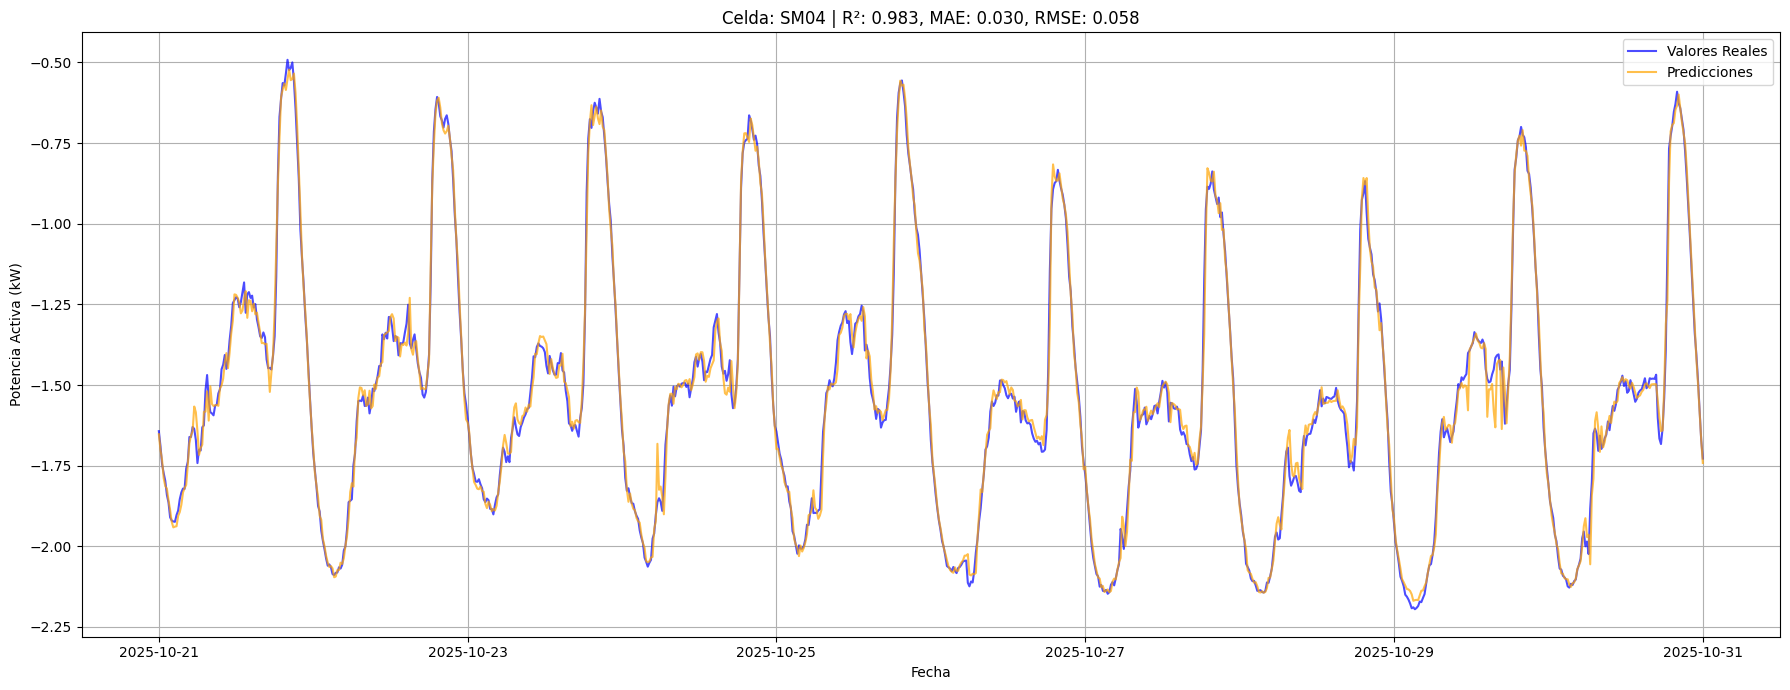

In [8]:
# Preparación para la visualización (últimos 10 días)
dias_a_mostrar = 10
y_test = y_test.sort_index()
ultimo_dia = y_test.index.max()
primer_dia = ultimo_dia - pd.Timedelta(days=dias_a_mostrar)

# Filtrar rango
mask = (y_test.index >= primer_dia) & (y_test.index <= ultimo_dia)
y_test_zoom = y_test.loc[mask]
y_pred_zoom = pd.Series(y_pred, index=y_test.index).loc[mask]

# Crear el título con las métricas formateadas
titulo_metricas = f"Celda: SM04 | R²: {r2:.3f}, MAE: {mae:.3f}, RMSE: {rmse:.3f}"

# Graficar comparación
plt.figure(figsize=(18, 7))
plt.plot(y_test_zoom.index, y_test_zoom, label='Valores Reales', color='blue', alpha=0.7)
plt.plot(y_pred_zoom.index, y_pred_zoom, label='Predicciones', color='orange', alpha=0.7)

plt.title(titulo_metricas) 
plt.xlabel('Fecha')
plt.ylabel('Potencia Activa (kW)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

